In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [ ]:
class Layer:
	def __init__(self, shape: int):
		self.shape = shape
		self.size = shape
		self.inputExcitatory = torch.zeros(self.size)
		self.inputInhibition = torch.zeros(self.size)
		self.v = torch.zeros(self.size)
		self.output = torch.zeros(self.size)
		self.prevOutput = torch.zeros(self.size)


class SpikingLayer(Layer):
	def __init__(self, shape: int):
		super().__init__(shape)
		self.refractoryTimer = torch.zeros(self.size)
		self.v.fill_(-70.0)
	def updateV(self):
		self.prevOutput = self.output
		#self.updateInhibit()
		refractory = self.refractoryTimer > 0.0; notRefractory = self.refractoryTimer <= 0.0
		for _ in range(2): # tries to fix oscillations. Oct 31
			netInput = self.inputExcitatory*(0.0-self.v) + self.inputInhibition*(-90-self.v) + 0.2*(-70.0-self.v) + torch.sigmoid((self.v+35.0)/2.0)*(145.0-self.v)
			self.v[notRefractory] += netInput[notRefractory]*0.5
		self.v[refractory] = -70.0 #+= (-70.0 - self.v[refractory]) * 0.6
		self.output = torch.logical_and(self.v > 0.0, notRefractory).float()
		self.refractoryTimer -= 1.0
		self.refractoryTimer[self.v > 0.0] = 3.0
		self.inputExcitatory=torch.zeros(self.size)
		self.inputInhibition=torch.zeros(self.size)

Oct 30, 2025 - Oct 31, 2025

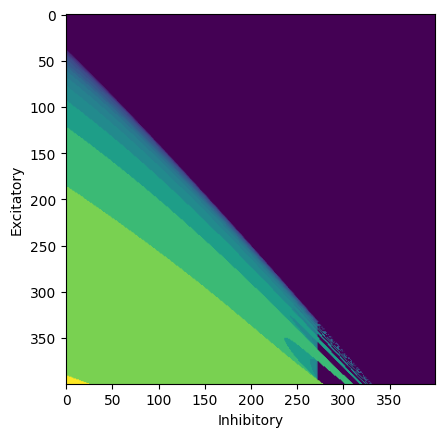

In [171]:
l=400
s=SpikingLayer(l*l)
count=torch.zeros(l*l)
excite = torch.arange(0,1,1/l)[:,None].expand(l,l).flatten()
inhib = torch.arange(0,1,1/l)[None,:].expand(l,l).flatten()
for i in range(100):
	#s.v+=torch.rand(l*l)*4-2
	s.inputExcitatory+=excite
	s.inputInhibition+=inhib
	s.updateV()
	count += s.output
plt.ylabel('Excitatory')
plt.xlabel('Inhibitory')
plt.imshow(count.reshape(l,l))

In [ ]:
e=torch.arange(0,1,1/l)[:,None].expand(l,l).flatten()
i=torch.arange(0,1,1/l)[None,:].expand(l,l).flatten()
def map2(v, min, max, min2, max2):
	return min2 + (max2 - min2) * ((v - min) / (max - min))
plt.imshow((torch.tanh(map2(e,i,1,0,1)*4.0).clamp_min(0)).view(l,l))

Oct 31, 2025

In [80]:
def updateInhibit(self):
	if not hasattr(self,"fastInhibition"):
		self.fastInhibition=torch.zeros(self.size)
		self.slowInhibition=torch.zeros(self.size)
	feedforwardInhibition = self.inputExcitatory.mean()
	feedbackInhibition = self.output.mean()
	self.fastInhibition.lerp_(feedforwardInhibition + feedbackInhibition, 1/6)
	self.slowInhibition.lerp_(feedbackInhibition, 1/50)
	self.inputInhibition+=self.fastInhibition+self.slowInhibition


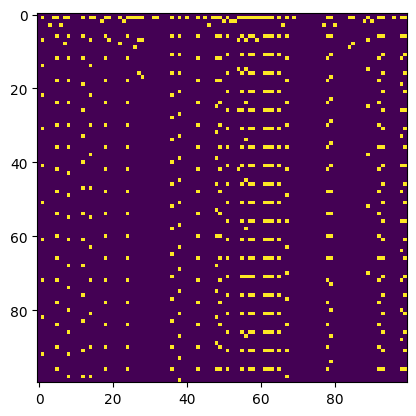

In [165]:
torch.manual_seed(1232)
l1=SpikingLayer(100)
l1act=[]
l2=SpikingLayer(100)
l2act=[]
inp=torch.rand(100)
for i in range(100):
	l1.inputExcitatory=inp
	updateInhibit(l1)
	l1.updateV()
	l1act.append(l1.output.clone())
	l2.inputExcitatory=l1.output.clone()
	updateInhibit(l2)
	l2.updateV()
	l2act.append(l2.output.clone())
#total=[tensor([list(a) for a in l1act]).sum(0)]
plt.imshow(l1act)